## Reducing Aviation Fatalities: A Neural Network approach using Pytorch

This kernel aims to create a neural network using pytorch. I am new to pytorch and I am still learning the nitty gritties of pytorch so if you find any mistakes or any imporvements that can be done please let me know in the comments section and I will be more than happy to address it.

**I am used a small subset of test set (10000 rows) to generate the predictions as the number of rows in test set is huge and everytime I try to load the test set and do some operations, kernel runs out of memory.  **

### TODO
* Calculate the accuracy of the model. As of now the code is commented out as I am not sure if I am doing it correctly

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
print(os.listdir("../input"))
print(torch.__version__)
%matplotlib inline

['sample_submission.csv', 'test.csv', 'train.csv']
1.0.1.post2


In [2]:
df_train = pd.read_csv("../input/train.csv")
df_train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,23.712299,-6.695870,29.232100,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,21.010300,-6.474720,26.641399,24.138800,5.46991,20.510599,2.83354,7.10177,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,25.431801,-0.088707,28.119900,26.891300,8.57886,23.162901,4.51993,12.70550,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,19.142799,-0.256516,30.653601,24.247000,8.64310,19.961901,7.27575,11.45980,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,20.572100,-1.953470,31.722601,25.155500,12.50030,18.746901,7.30976,8.00805,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [3]:
df_train.shape

(4867421, 28)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
crew          int64
experiment    object
time          float64
seat          int64
eeg_fp1       float64
eeg_f7        float64
eeg_f8        float64
eeg_t4        float64
eeg_t6        float64
eeg_t5        float64
eeg_t3        float64
eeg_fp2       float64
eeg_o1        float64
eeg_p3        float64
eeg_pz        float64
eeg_f3        float64
eeg_fz        float64
eeg_f4        float64
eeg_c4        float64
eeg_p4        float64
eeg_poz       float64
eeg_c3        float64
eeg_cz        float64
eeg_o2        float64
ecg           float64
r             float64
gsr           float64
event         object
dtypes: float64(24), int64(2), object(2)
memory usage: 1.0+ GB


In [5]:
#Use only a small subset of the Test set.
df_test = pd.read_csv("../input/test.csv", nrows=10000)
df_test.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,-187.080002,-33.183498,-4.220780,8.178160,33.160301,33.812500,21.744699,16.293800,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,-5.145290,6.395940,33.420101,-295.013000,8.373170,29.636400,16.223000,850.288025,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,-107.236000,12.845200,1.215280,13.317000,44.435101,37.585800,29.073000,22.316099,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,-8.021180,7.427430,27.345699,-310.165009,5.389070,27.733999,7.217500,816.679016,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,37.007900,-50.334202,-11.676400,-1.143860,-17.600500,34.075600,22.912399,19.033800,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


In [6]:
df_test.shape

(10000, 28)

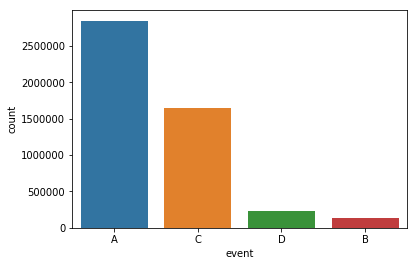

In [7]:
sns.countplot(x='event', data=df_train)

In [8]:
print(df_train['experiment'].unique())
print(df_test['experiment'].unique())

['CA' 'DA' 'SS']
['LOFT']


In [9]:
dic = {'CA': 0, 'DA': 1, 'SS': 2, 'LOFT': 3}
df_train["experiment"] = df_train["experiment"].apply(lambda x: dic[x])
df_test["experiment"] = df_test["experiment"].apply(lambda x: dic[x])

In [10]:
dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
df_train["event"] = df_train["event"].apply(lambda x: dic[x])

In [11]:
X = df_train.drop(columns=['event'], axis = 1)
Y = df_train['event']

In [12]:
X.shape

(4867421, 27)

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [15]:
def to_categorical(y, num_classes):
    """1-hot encodes a tensor"""
    return np.eye(num_classes, dtype='uint8')[y]

In [16]:
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

In [17]:
y_train.shape

(3893936, 4)

In [18]:
featuresTrain = torch.from_numpy(X_train).float()
targetsTrain = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

In [19]:
featuresValid = torch.from_numpy(X_valid).float()
targetsValid = torch.from_numpy(y_valid).type(torch.LongTensor) # data type is long

In [20]:
X_test = df_test.drop(['id'], axis = 1)
X_test.shape

(10000, 27)

In [21]:
X_test_scaled = scaler.transform(X_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [22]:
featuresTest = torch.from_numpy(X_test_scaled).float()

In [23]:
batch_size = 512
num_epochs = 100
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
valid = torch.utils.data.TensorDataset(featuresValid,targetsValid)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = True)

In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, n_neurons, dropouts):
        super().__init__()
        self.layer1 = nn.Linear(in_features=n_features, out_features=n_neurons[0])
        self.dropout1 = nn.Dropout(dropouts[0])
        self.layer2 = nn.Linear(in_features=n_neurons[0], out_features=n_neurons[1])
        self.dropout2 = nn.Dropout(dropouts[1])
        self.out_layer = nn.Linear(in_features=n_neurons[1], out_features=4)
     
    def forward(self, X):
        out = F.relu(self.layer1(X))
        out = self.dropout1(out)
        out = F.relu(self.layer2(out))
        out = self.dropout2(out)
        out = self.out_layer(out)
        return F.log_softmax(out, dim=1)
        

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_features = 27
n_neurons = [100, 50]
dropouts = [0.3, 0.2]
model = NeuralNetwork(n_features, n_neurons, dropouts)
model = model.to(device)
# Cross Entropy Loss 
error = nn.NLLLoss()
# Adam Optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# train_losses = []
# train_acc = []
# valid_losses = []
# valid_acc = []
num_epochs = 5
for e in range(num_epochs):
    start_time = time.time()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        #print(labels)
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = error(outputs, torch.max(labels, 1)[1])
        #loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        # update training loss
        train_loss += loss.item()*features.size(0)
        
        #TODO: Calculate the accuracy on the train test
        #acc = torch.eq(outputs.round(), labels).float().mean() # accuracy
        #_, predicted = torch.max(outputs.data, 1)
        #_, actual = torch.max(labels, 1)
        #total = len(labels)
        #correct = (predicted == actual).sum()
        #train_accuracy = 100 * correct / total
        #train_losses.append(train_loss.item())
        #train_acc.append(train_accuracy.item())
        
    model.eval()
    for i, (features, labels) in enumerate(valid_loader):
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = error(outputs, torch.max(labels, 1)[1])
        #loss = error(outputs, labels)
        valid_loss += loss.item()*features.size(0)
        
        #_, predicted = torch.max(outputs.data, 1)
        #_, actual = torch.max(labels, 1)
        #total = len(labels)
        #correct = (predicted == actual).sum()
        #accuracy = 100 * correct / total
        #valid_losses.append(loss.item())
        #valid_acc.append(accuracy.item())
    
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    elapsed_time = time.time() - start_time
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime: {:.2f}'.format(
        e+1, train_loss, valid_loss, elapsed_time))    
    
#     if e % 1 == 0:
#         print("[{}/{}], Train Loss: {} Train Acc: {}, Validation Loss : {}, Validation Acc: {} ".format(e+1,
#         num_epochs, np.round(train_loss.item(), 3), np.round(train_accuracy.item(), 3), 
#         np.round(loss.item(), 3), np.round(accuracy.item(), 3)))

Epoch: 1 	Training Loss: 0.204602 	Validation Loss: 0.161350 	Time: 44.16
Epoch: 2 	Training Loss: 0.173000 	Validation Loss: 0.144081 	Time: 43.09
Epoch: 3 	Training Loss: 0.164323 	Validation Loss: 0.141127 	Time: 43.59
Epoch: 4 	Training Loss: 0.161344 	Validation Loss: 0.135288 	Time: 44.57
Epoch: 5 	Training Loss: 0.156200 	Validation Loss: 0.141451 	Time: 42.61


In [27]:
test = torch.utils.data.TensorDataset(featuresTest)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
test_preds = np.zeros((len(test), 4))

for i, (x_batch,) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    y_pred = model(x_batch).detach()
    test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred.cpu().numpy()

In [28]:
test_preds.shape

(10000, 4)

In [29]:
test_preds[100:110, :]

array([[    0.        ,  -128.58291626, -1390.7175293 ,  -174.84936523],
       [    0.        ,   -37.63380814,  -124.42996216,   -53.15888977],
       [    0.        ,  -135.35681152, -1393.0715332 ,  -174.17381287],
       [    0.        ,   -37.0456543 ,  -122.53819275,   -52.34250641],
       [    0.        ,  -139.08337402, -1338.77624512,  -171.26495361],
       [    0.        ,   -36.44495392,  -120.6060791 ,   -51.50871658],
       [    0.        ,  -129.30172729, -1334.1940918 ,  -174.09060669],
       [    0.        ,   -37.34476471,  -123.50026703,   -52.7576828 ],
       [    0.        ,  -143.90472412, -1429.71655273,  -183.54248047],
       [    0.        ,   -37.39890289,  -123.67440033,   -52.83283234]])

In [ ]:
submission = pd.DataFrame({'id':df_test['id'],'A':test_preds[:, 0], 'B':test_preds[:, 1],
                          'C':test_preds[:, 2], 'D':test_preds[:, 3]})
submission.head()